# Introduction

Download DCC processed data of old ("rice" grain) and new Rush brain.

# Notebook setup

In [1]:
from io import StringIO
import numpy
import pandas
from pathlib import Path
import re
import requests
import sys
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr
import seaborn

In [2]:
!{sys.executable} -m pip install encoded_client

In [3]:
from encoded_client import ENCODED

server = ENCODED("www.encodeproject.org")

In [4]:
flowcell_dir = Path("~/proj/flowcells").expanduser()

In [5]:
list(flowcell_dir.glob("*rush*.xlsx"))

[PosixPath('/woldlab/loxcyc/home/diane/proj/flowcells/stranded-24293-24316-rush-resubmit.xlsx'),
 PosixPath('/woldlab/loxcyc/home/diane/proj/flowcells/stranded-22951-23100-rush-brain.xlsx'),
 PosixPath('/woldlab/loxcyc/home/diane/proj/flowcells/stranded-24388-24412-rush-resubmit.xlsx'),
 PosixPath('/woldlab/loxcyc/home/diane/proj/flowcells/stranded-24038-24534-rush-resubmit-all.xlsx'),
 PosixPath('/woldlab/loxcyc/home/diane/proj/flowcells/stranded-24038-24061-rush-resubmit.xlsx'),
 PosixPath('/woldlab/loxcyc/home/diane/proj/flowcells/stranded-24196-24219-rush-resubmit.xlsx'),
 PosixPath('/woldlab/loxcyc/home/diane/proj/flowcells/stranded-24511-24534-rush-resubmit.xlsx')]

# Load the submission spreadsheets

In [6]:
orig_submission_filename = flowcell_dir / "stranded-22951-23100-rush-brain.xlsx"

orig_biosamples = pandas.read_excel(orig_submission_filename, sheet_name="Biosample")
orig_experiments = pandas.read_excel(orig_submission_filename, sheet_name="Experiment")
orig_libraries = pandas.read_excel(orig_submission_filename, sheet_name="Library")

In [7]:
orig_biosamples["rush_id:skip"] = orig_biosamples["donor"].apply(lambda x: x.split(":")[1])

In [8]:
new_submissions = sorted(flowcell_dir.glob("stranded*-rush-resubmit.xlsx"))

terms = ["Biosample", "Experiment", "Library", "Replicate", "File"]
current_books = {}
totals = {}

for filename in new_submissions:
    book = pandas.ExcelFile(filename)
    for term in terms:
        sheet = book.parse(sheet_name=term)
        if sheet.shape[0] > 1000:
            print("Execessive sheet size {} {} {}".format(filename, term, sheet.shape[0]))
        else:
            print("Sheet {} {} {}".format(filename, term, sheet.shape[0]))
        totals[term] = totals.get(term, 0) + sheet.shape[0]            
        #sheet = sheet.dropna()
        current_books.setdefault(term, []).append(sheet)
    print()

print(totals)

Sheet /woldlab/loxcyc/home/diane/proj/flowcells/stranded-24038-24061-rush-resubmit.xlsx Biosample 24
Sheet /woldlab/loxcyc/home/diane/proj/flowcells/stranded-24038-24061-rush-resubmit.xlsx Experiment 24
Sheet /woldlab/loxcyc/home/diane/proj/flowcells/stranded-24038-24061-rush-resubmit.xlsx Library 24
Sheet /woldlab/loxcyc/home/diane/proj/flowcells/stranded-24038-24061-rush-resubmit.xlsx Replicate 24
Sheet /woldlab/loxcyc/home/diane/proj/flowcells/stranded-24038-24061-rush-resubmit.xlsx File 24

Sheet /woldlab/loxcyc/home/diane/proj/flowcells/stranded-24196-24219-rush-resubmit.xlsx Biosample 26
Sheet /woldlab/loxcyc/home/diane/proj/flowcells/stranded-24196-24219-rush-resubmit.xlsx Experiment 24
Sheet /woldlab/loxcyc/home/diane/proj/flowcells/stranded-24196-24219-rush-resubmit.xlsx Library 24
Sheet /woldlab/loxcyc/home/diane/proj/flowcells/stranded-24196-24219-rush-resubmit.xlsx Replicate 24
Sheet /woldlab/loxcyc/home/diane/proj/flowcells/stranded-24196-24219-rush-resubmit.xlsx File 24



In [9]:
new_sheets = {}
for term in terms:
    sheet = pandas.concat(current_books[term])
    print(term, sheet.shape[0])
    new_sheets[term] = sheet

Biosample 122
Experiment 120
Library 120
Replicate 120
File 120


# Try to add cogdx scores

In [10]:
cogdx_sheet = pandas.read_excel(
    "https://woldlab.caltech.edu/nextcloud/index.php/s/zp2cMpAEEEyb32A/download",
    dtype={
        "msex": int,
        "educ": int,
        "race7": int,
        "cogdx": int,
    }
)
cogdx_sheet = cogdx_sheet.rename(columns={"educ": "education:skip", "race7": "race", "cogdx": "cogdx:skip"})
cogdx_sheet.head()

,rushid,msex,education:skip,race,cogdx:skip,age_death
0,E4946143,1,9,1,4,87.8631075
1,E4368365,1,13,1,4,90+
2,E8969200,1,21,1,1,86.5051335
3,E7204277,1,18,1,1,87.9534565
4,E8277356,1,22,1,4,90+


In [11]:
new_sheets["Biosample"].head()

,uuid,accession,rush_id:skip,age:skip,age_units:skip,sex:skip,clinical_status:skip,library_id:skip,cDNA_sample:skip,description,biosample_ontology,biosample_term_name:skip,aliases:array,organism,source,donor,lab,award,nih_institutional_certification
0,801ba381-6ee9-4633-bf42-9ea31f835ad0,ENCBS075IEY,E3453103,90 or above,year,female,NCI,24038.0,ENC4_cDNA649,human_brain_Rush ID_3453103_BS49_ENC4_cDNA649,/biosample-types/tissue_UBERON_0006483/,mid frontal cortex,barbara-wold:ENC4_cDNA649,/organisms/human/,/sources/rush-university/,john-stamatoyannopoulos:E3453103,barbara-wold,UM1HG009443,NaN
1,a6076606-2b3b-4b5e-99bb-8c6ab5125147,ENCBS742MVD,E4163791,90 or above,year,female,NCI,24039.0,ENC4_cDNA650,human_brain_Rush ID_4163791_BS53_ENC4_cDNA650,/biosample-types/tissue_UBERON_0006483/,mid frontal cortex,barbara-wold:ENC4_cDNA650,/organisms/human/,/sources/rush-university/,john-stamatoyannopoulos:E4163791,barbara-wold,UM1HG009443,NaN
2,ed956add-e8b9-47dd-8bdc-9b944dde5847,ENCBS644WSW,E4368365,90 or above,year,male,NINCDS PROB AD,24040.0,ENC4_cDNA651,human_brain_Rush ID_4368365_BS62_ENC4_cDNA651,/biosample-types/tissue_UBERON_0006483/,mid frontal cortex,barbara-wold:ENC4_cDNA651,/organisms/human/,/sources/rush-university/,john-stamatoyannopoulos:E4368365,barbara-wold,UM1HG009443,NaN
3,80fe3505-9c40-4531-98f7-be875b3c11a6,ENCBS436WHA,E4933693,90 or above,year,female,NINCDS PROB AD,24041.0,ENC4_cDNA652,human_brain_Rush ID_4933693_BS56_ENC4_cDNA652,/biosample-types/tissue_UBERON_0006483/,mid frontal cortex,barbara-wold:ENC4_cDNA652,/organisms/human/,/sources/rush-university/,john-stamatoyannopoulos:E4933693,barbara-wold,UM1HG009443,NaN
4,6e457a60-788f-449e-b8ac-92d8bb790c2b,ENCBS105DDE,E5115600,88,year,female,NCI,24042.0,ENC4_cDNA653,human_brain_Rush ID_5115600_BS16_ENC4_cDNA653,/biosample-types/tissue_UBERON_0006483/,mid frontal cortex,barbara-wold:ENC4_cDNA653,/organisms/human/,/sources/rush-university/,john-stamatoyannopoulos:E5115600,barbara-wold,UM1HG009443,NaN


In [12]:
annotated_biosamples = new_sheets["Biosample"].merge(cogdx_sheet, left_on="rush_id:skip", right_on="rushid")
annotated_biosamples

,uuid,accession,rush_id:skip,age:skip,age_units:skip,sex:skip,clinical_status:skip,library_id:skip,cDNA_sample:skip,description,...,donor,lab,award,nih_institutional_certification,rushid,msex,education:skip,race,cogdx:skip,age_death
0,801ba381-6ee9-4633-bf42-9ea31f835ad0,ENCBS075IEY,E3453103,90 or above,year,female,NCI,24038.0,ENC4_cDNA649,human_brain_Rush ID_3453103_BS49_ENC4_cDNA649,...,john-stamatoyannopoulos:E3453103,barbara-wold,UM1HG009443,NaN,E3453103,0,23,1,1,90+
1,a6076606-2b3b-4b5e-99bb-8c6ab5125147,ENCBS742MVD,E4163791,90 or above,year,female,NCI,24039.0,ENC4_cDNA650,human_brain_Rush ID_4163791_BS53_ENC4_cDNA650,...,john-stamatoyannopoulos:E4163791,barbara-wold,UM1HG009443,NaN,E4163791,0,16,1,1,90+
2,ab5a3aeb-ab2c-479f-a4d6-28ba6e24a178,ENCBS819UHF,E4163791,90 or above,year,female,NCI,24054.0,ENC4_cDNA665,human_brain_Rush ID_4163791_BS115_ENC4_cDNA665,...,john-stamatoyannopoulos:E4163791,barbara-wold,UM1HG009443,NaN,E4163791,0,16,1,1,90+
3,ed956add-e8b9-47dd-8bdc-9b944dde5847,ENCBS644WSW,E4368365,90 or above,year,male,NINCDS PROB AD,24040.0,ENC4_cDNA651,human_brain_Rush ID_4368365_BS62_ENC4_cDNA651,...,john-stamatoyannopoulos:E4368365,barbara-wold,UM1HG009443,NaN,E4368365,1,13,1,4,90+
4,80fe3505-9c40-4531-98f7-be875b3c11a6,ENCBS436WHA,E4933693,90 or above,year,female,NINCDS PROB AD,24041.0,ENC4_cDNA652,human_brain_Rush ID_4933693_BS56_ENC4_cDNA652,...,john-stamatoyannopoulos:E4933693,barbara-wold,UM1HG009443,NaN,E4933693,0,16,1,4,90+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,b003834d-a2b9-4948-9ca9-690c4b7e64cb,ENCBS979TED,E8522907,90 or above,year,female,MCI + CI,24530.0,ENC4_cDNA769,human_brain_Rush ID_E8522907_BS214_ENC4_cDNA769,...,john-stamatoyannopoulos:E8522907,barbara-wold,UM1HG009443,NIC00058,E8522907,0,20,1,3,90+
118,31e09a19-b2a4-4bdf-aed8-d36721137c7d,ENCBS589OUP,E8792932,89,year,male,MCI + no CI,24531.0,ENC4_cDNA770,human_brain_Rush ID_E8792932_BS215_ENC4_cDNA770,...,john-stamatoyannopoulos:E8792932,barbara-wold,UM1HG009443,NIC00058,E8792932,1,14,1,2,89.3223819
119,1f03fbc6-1dd0-4be7-9d0c-029140e8fc6f,ENCBS159MAA,E9254359,90 or above,year,female,MCI + no CI,24532.0,ENC4_cDNA771,human_brain_Rush ID_E9254359_BS216_ENC4_cDNA771,...,john-stamatoyannopoulos:E9254359,barbara-wold,UM1HG009443,NIC00058,E9254359,0,13,1,2,90+
120,838bd447-1cf6-4fbe-af3f-1bba4f9ce47e,ENCBS626ZIO,E9687283,90 or above,year,female,MCI + CI,24533.0,ENC4_cDNA772,human_brain_Rush ID_E9687283_BS217_ENC4_cDNA772,...,john-stamatoyannopoulos:E9687283,barbara-wold,UM1HG009443,NIC00058,E9687283,0,7,1,3,90+


In [13]:
health_term_ids = []
health_term_names = []
donor_ids = []
for i, row in tqdm(annotated_biosamples.iterrows(), total=annotated_biosamples.shape[0]):
    biosample = server.get_json(row["accession"])
    health_term_ids.append(biosample.get("disease_term_id"))
    health_term_names.append(biosample.get("disease_term_name"))
    donor_ids.append(biosample["donor"]["accession"])

annotated_biosamples["disease_term_id:skip"] = health_term_ids
annotated_biosamples["disease_term_name:skip"] = health_term_names
annotated_biosamples["donor_accession:skip"] = donor_ids

100%|██████████| 122/122 [00:27<00:00,  4.40it/s]


In [14]:
annotated_biosamples[["clinical_status:skip", "cogdx:skip", "disease_term_name:skip"]]

,clinical_status:skip,cogdx:skip,disease_term_name:skip
0,NCI,1,None
1,NCI,1,None
2,NCI,1,None
3,NINCDS PROB AD,4,[Alzheimer's disease]
4,NINCDS PROB AD,4,[Alzheimer's disease]
...,...,...,...
117,MCI + CI,3,[Cognitive impairment]
118,MCI + no CI,2,[mild cognitive impairment]
119,MCI + no CI,2,[mild cognitive impairment]
120,MCI + CI,3,[Cognitive impairment]


In [15]:
annotated_biosamples[["clinical_status:skip", "cogdx:skip", "disease_term_name:skip"]][annotated_biosamples["cogdx:skip"] == 4].head()

,clinical_status:skip,cogdx:skip,disease_term_name:skip
3,NINCDS PROB AD,4,[Alzheimer's disease]
4,NINCDS PROB AD,4,[Alzheimer's disease]
7,NINCDS PROB AD,4,[Alzheimer's disease]
8,NINCDS PROB AD,4,[Alzheimer's disease]
9,NINCDS PROB AD,4,[Alzheimer's disease]


In [16]:
annotated_biosamples[["clinical_status:skip", "cogdx:skip", "disease_term_name:skip"]][annotated_biosamples["cogdx:skip"] == 5].head()

,clinical_status:skip,cogdx:skip,disease_term_name:skip
18,NINCDS POSS AD,5,"[Alzheimer's disease, Cognitive impairment]"
22,NINCDS POSS AD,5,"[Alzheimer's disease, Cognitive impairment]"
80,NINCDS POSS AD,5,"[Cognitive impairment, Alzheimer's disease]"
81,NINCDS POSS AD,5,"[Cognitive impairment, Alzheimer's disease]"
84,NINCDS POSS AD,5,"[Cognitive impairment, Alzheimer's disease]"


In [17]:
cogdx_to_comment = {
    1: "NCI",
    2: "MCI + no CI",
    3: "MCI + CI",
    4: "NINCDS PROB AD",
    5: "NINCDS POSS AD",
}

In [18]:
comment_to_disease_status = {
    "NCI": None,
    "MCI + no CI": ["mild cognitive impairment"],
    "MCI + CI": ["Cognitive impairment"], 
    "NINCDS PROB AD": ["Alzheimer's disease"],
    "NINCDS POSS AD": ["Alzheimer's disease", "Cognitive impairment"],
}

In [19]:
for i, row in annotated_biosamples.iterrows():
    if row.msex == 0 and row['sex:skip'] == "female":
        pass
    elif row.msex == 1 and row["sex:skip"] == "male":
        pass
    else:
        print("Unexpected sex coding {} {} {}".format(row["rush_id:skip"], row.msex, row["sex.skip"]))
        
    if row["age_death"] == "90+" and row["age:skip"] == "90 or above":
        pass
    elif row["age_death"] == "90+" or row["age:skip"] == "90 or above":
        print("unexpected age coding {} {} {} {}".format(row["rush_id:skip"], row["age_death"], age_death, row["age:skip"]))        
    else:
        age_death = int(float(row["age_death"]))
        if age_death == int(row["age:skip"]):
            pass
        else:
            print("unexpected age coding {} {} {} {}".format(row["rush_id:skip"], row["age_death"], age_death, row["age:skip"]))
     
    if cogdx_to_comment[row["cogdx:skip"]] != row["clinical_status:skip"]:
        print("unexpected cogdx coding {} {} {} {}".format(row["rush_id:skip"], row["cogdx:skip"], row["clinical_status:skip"]))

    if row["clinical_status:skip"] == "NCI" and row["disease_term_name:skip"] is None:
        pass
    elif set(comment_to_disease_status[row["clinical_status:skip"]]) == set(row["disease_term_name:skip"]):
        pass
    else:
        print("unexpected disease status2 {} {} {} {}".format(row["rush_id:skip"], row["cogdx:skip"], row["clinical_status:skip"], row["disease_term_name:skip"]))
        
        

unexpected age coding E7886851 89.7138946 89 90 or above


There is an inconsistency between what was posted to the portal and what Brian had

In [20]:
annotated_biosamples[annotated_biosamples["rush_id:skip"] == "E7886851"]

,uuid,accession,rush_id:skip,age:skip,age_units:skip,sex:skip,clinical_status:skip,library_id:skip,cDNA_sample:skip,description,...,nih_institutional_certification,rushid,msex,education:skip,race,cogdx:skip,age_death,disease_term_id:skip,disease_term_name:skip,donor_accession:skip
66,57a050e7-4df2-4b67-b753-4888e2f5eee7,ENCBS544WUH,E7886851,90 or above,year,male,NINCDS PROB AD,24310.0,ENC4_cDNA714,human_brain_Rush ID_E7886851_BS164_ENC4_cDNA714,...,NIC00058,E7886851,1,21,1,4,89.7138946,[DOID:10652],[Alzheimer's disease],ENCDO741BVY


In [21]:
assert set(annotated_biosamples["race"]) == {1}, "Message there are now more sex values. We should add it to the sheet."

Reorder sheet to put interesting stuff toward the front

In [22]:
annotated_biosamples.columns

Index(['uuid', 'accession', 'rush_id:skip', 'age:skip', 'age_units:skip',
       'sex:skip', 'clinical_status:skip', 'library_id:skip',
       'cDNA_sample:skip', 'description', 'biosample_ontology',
       'biosample_term_name:skip', 'aliases:array', 'organism', 'source',
       'donor', 'lab', 'award', 'nih_institutional_certification', 'rushid',
       'msex', 'education:skip', 'race', 'cogdx:skip', 'age_death',
       'disease_term_id:skip', 'disease_term_name:skip',
       'donor_accession:skip'],
      dtype='object')

In [23]:
new_sheets["Biosample"] = annotated_biosamples[['uuid', 'accession', 'rush_id:skip', 'age:skip', 'age_units:skip',
       'sex:skip', "education:skip", "cogdx:skip", 'clinical_status:skip', 'disease_term_name:skip', 'library_id:skip',
       'cDNA_sample:skip', 'description', 'biosample_ontology',
       'biosample_term_name:skip', 'aliases:array', 'organism', 'source',
       'donor', 'donor_accession:skip', 'lab', 'award', 'nih_institutional_certification', 'disease_term_id:skip']]

# Save merged resubmit spreadsheet

Though some of the tables were smaller than expected?

In [24]:
with pandas.ExcelWriter(flowcell_dir / "stranded-24038-24534-rush-resubmit-all.xlsx") as book:
    for term in terms:
        new_sheets[term].to_excel(book, term, index=False)


# Merge original submission biosample and experiment sheets

In [25]:
orig_table = orig_biosamples.merge(
    orig_experiments, 
    left_on=["description", "biosample_ontology", "lab", "award"], 
    right_on=["description", "biosample_ontology", "lab", "award"], 
    suffixes=("_biosample", "_experiment"))

print(orig_table.shape)
orig_table.head()

(119, 18)


,uuid_biosample,accession_biosample,aliases:array_biosample,biosample_ontology,biosample_term_name:skip,description,library_id:skip,cDNA_sample:skip,donor,organism,source,lab,award,rush_id:skip,uuid_experiment,accession_experiment,aliases:array_experiment,assay_term_name
0,abe5e219-b7a0-4b88-9c67-a7aca5dd7bce,ENCBS562TCG,barbara-wold:ENC4_cDNA319,/biosample-types/tissue_UBERON_0006483/,mid frontal cortex; dorsolateral prefrontal co...,RUSH_AD_MFC_E5115600_ENC4_cDNA319,22951,ENC4_cDNA319,john-stamatoyannopoulos:E5115600,/organisms/human/,/sources/rush-university/,barbara-wold,UM1HG009443,E5115600,a966cd6c-5cb7-4689-aff9-9e7d47628c26,ENCSR098AHH,barbara-wold:RUSH_AD_MFC_E5115600_ENC4_cDNA319,RNA-seq
1,1d7a3d8a-fc0c-4e0f-b866-2f25d08d9ce8,ENCBS061VZK,barbara-wold:ENC4_cDNA320,/biosample-types/tissue_UBERON_0006483/,NaN,RUSH_AD_MFC_E6260868_ENC4_cDNA320,22952,ENC4_cDNA320,john-stamatoyannopoulos:E6260868,/organisms/human/,/sources/rush-university/,barbara-wold,UM1HG009443,E6260868,f1de378c-fff0-4c65-a8b1-eebd4204fdea,ENCSR971VVX,barbara-wold:RUSH_AD_MFC_E6260868_ENC4_cDNA320,RNA-seq
2,fa8bce7a-efdb-438a-a9ae-15de5b28c523,ENCBS963WHI,barbara-wold:ENC4_cDNA321,/biosample-types/tissue_UBERON_0006483/,NaN,RUSH_AD_MFC_E2585111_ENC4_cDNA321,22953,ENC4_cDNA321,john-stamatoyannopoulos:E2585111,/organisms/human/,/sources/rush-university/,barbara-wold,UM1HG009443,E2585111,259283c5-6ffa-42f4-b8fb-9aef65c26e15,ENCSR999LNM,barbara-wold:RUSH_AD_MFC_E2585111_ENC4_cDNA321,RNA-seq
3,aa7ce841-dbaf-4ede-9a35-580c306923f4,ENCBS433BLR,barbara-wold:ENC4_cDNA322,/biosample-types/tissue_UBERON_0006483/,NaN,RUSH_AD_MFC_E7431498_ENC4_cDNA322,22954,ENC4_cDNA322,john-stamatoyannopoulos:E7431498,/organisms/human/,/sources/rush-university/,barbara-wold,UM1HG009443,E7431498,4d5c5590-4c75-41be-8884-2d777c516a3e,ENCSR180BEF,barbara-wold:RUSH_AD_MFC_E7431498_ENC4_cDNA322,RNA-seq
4,812d2504-8b5f-4da1-9417-573ba0dfef18,ENCBS327DMH,barbara-wold:ENC4_cDNA323,/biosample-types/tissue_UBERON_0006483/,NaN,RUSH_AD_MFC_E7286104_ENC4_cDNA323,22955,ENC4_cDNA323,john-stamatoyannopoulos:E7286104,/organisms/human/,/sources/rush-university/,barbara-wold,UM1HG009443,E7286104,1ae59450-75ce-475e-b25f-1132c096a00a,ENCSR315IMH,barbara-wold:RUSH_AD_MFC_E7286104_ENC4_cDNA323,RNA-seq


# Merge new submission biosample and experiment sheets

In [26]:
new_table = new_sheets["Biosample"].merge(
    new_sheets["Experiment"], 
    left_on=["description", "biosample_ontology", "lab", "award"], 
    right_on=["description", "biosample_ontology", "lab", "award"], 
    suffixes=("_biosample", "_experiment"))

print(new_table.shape)
new_table.head()


(120, 30)


,uuid_biosample,accession_biosample,rush_id:skip,age:skip,age_units:skip,sex:skip,education:skip,cogdx:skip,clinical_status:skip,disease_term_name:skip,...,lab,award,nih_institutional_certification,disease_term_id:skip,uuid_experiment,accession_experiment,aliases:array_experiment,library_id:skip_experiment,biosample_ontology_term_name:skip,assay_term_name
0,801ba381-6ee9-4633-bf42-9ea31f835ad0,ENCBS075IEY,E3453103,90 or above,year,female,23,1,NCI,None,...,barbara-wold,UM1HG009443,NaN,None,b8b01b8f-fe45-4a92-9662-bec8e6757db9,ENCSR365ARV,barbara-wold:human_brain_Rush_ID_3453103_BS49_...,24038,mid frontal cortex,RNA-seq
1,a6076606-2b3b-4b5e-99bb-8c6ab5125147,ENCBS742MVD,E4163791,90 or above,year,female,16,1,NCI,None,...,barbara-wold,UM1HG009443,NaN,None,be2f2dce-9632-4209-939f-b7b8171855fd,ENCSR061HMO,barbara-wold:human_brain_Rush_ID_4163791_BS53_...,24039,mid frontal cortex,RNA-seq
2,ab5a3aeb-ab2c-479f-a4d6-28ba6e24a178,ENCBS819UHF,E4163791,90 or above,year,female,16,1,NCI,None,...,barbara-wold,UM1HG009443,NaN,None,4786bd91-60a0-4853-a41a-81aca7018b91,ENCSR562BUN,barbara-wold:human_brain_Rush_ID_4163791_BS115...,24054,mid frontal cortex,RNA-seq
3,ed956add-e8b9-47dd-8bdc-9b944dde5847,ENCBS644WSW,E4368365,90 or above,year,male,13,4,NINCDS PROB AD,[Alzheimer's disease],...,barbara-wold,UM1HG009443,NaN,[DOID:10652],28d0423d-2451-4511-abaa-79d4246313c5,ENCSR875MVZ,barbara-wold:human_brain_Rush_ID_4368365_BS62_...,24040,mid frontal cortex,RNA-seq
4,80fe3505-9c40-4531-98f7-be875b3c11a6,ENCBS436WHA,E4933693,90 or above,year,female,16,4,NINCDS PROB AD,[Alzheimer's disease],...,barbara-wold,UM1HG009443,NaN,[DOID:10652],f3a41277-d3ca-4e3a-b5eb-595e55d05a9e,ENCSR648JOK,barbara-wold:human_brain_Rush_ID_4933693_BS56_...,24041,mid frontal cortex,RNA-seq


# Compare donors in both sets

It appears there were a couple of donors that appeared in the new set and one donor that was only in the old set.

In [27]:
set(orig_table["rush_id:skip"]).difference(new_table["rush_id:skip"])

{'E6128836', 'E6260868'}

In [28]:
set(new_table["rush_id:skip"]).difference(orig_table["rush_id:skip"])

{'E6590998'}

# Retrieve the TPMs from all rsem gene quantifications

In [29]:
def get_gene_quantification_metadata(experiment_id):
    experiment = server.get_json(experiment_id)
    assert len(experiment["replicates"]) == 1
    
    library = experiment["replicates"][0]["library"]
    biosample = library["biosample"]
    donor = biosample["donor"]
    default_analysis = experiment["default_analysis"]
    metadata = []
    for f in experiment["files"]:
        analyses = [x["@id"] for x in f["analyses"]]
        # this check only applies to processed data not reads (default_analysis in analyses and)
        if f["output_type"] in ("gene quantifications",) and default_analysis in analyses:
            reps = f["technical_replicates"]
            assert len(reps) == 1
            reps = reps[0]
            
            #extension = {
            #    "fastq": ".fastq.gz",
            #    "bam": ".bam",
            #}[f["file_format"]]
            #target_name = "{}_{}_{}_{}{}".format(experiment["accession"], reps, f["accession"], f["output_type"], extension)
            #if cache_dir is None:
            #    cache_dir = os.getcwd()
            #cache_dir = Path(cache_dir)
            #target = cache_dir / target_name
            
            #if not target.exists() or target.lstat().st_size != f["file_size"]:
            #    with server.get_response(f["href"], stream=True) as response:
            #        with open(target, 'wb') as outstream:
            #            shutil.copyfileobj(response.raw, outstream)

            metadata.append({
                "experiment": experiment["accession"],
                "library": library["accession"],
                "biosample": biosample["accession"],
                "donor": donor["accession"],
                "simple_biosample_summary": f["simple_biosample_summary"],
                "file": f["accession"],
                "output_type": f["output_type"],
                "file_size": f["file_size"],

                "tech_rep": f["technical_replicates"][0],
                "href": server.prepare_url(f["href"]),
            })
    return metadata

get_gene_quantification_metadata("ENCSR365ARV")


[{'experiment': 'ENCSR365ARV',
  'library': 'ENCLB386AZN',
  'biosample': 'ENCBS075IEY',
  'donor': 'ENCDO006DAA',
  'simple_biosample_summary': 'female adult (90 or above years)',
  'file': 'ENCFF284VFV',
  'output_type': 'gene quantifications',
  'file_size': 10998264,
  'tech_rep': '1_1',
  'href': 'https://www.encodeproject.org/files/ENCFF284VFV/@@download/ENCFF284VFV.tsv'}]

In [30]:
def get_column(url, column="TPM"):
    try:
        if isinstance(url, str) and re.match('https?://', url):
            r = requests.get(url)
            stream = StringIO(r.text)
        else:
            stream = url
        table = pandas.read_csv(stream,
                                sep='\t',
                                index_col=0)
    except pandas.io.common.EmptyDataError as e:
        logger.error("Unable to read file {} empty data".format(filename))
        sys.exit(1)

    return table[[column]]

get_column('https://www.encodeproject.org/files/ENCFF284VFV/@@download/ENCFF284VFV.tsv', "TPM").head()

,TPM
gene_id,
10904,0.0
12954,0.0
12956,0.0
12958,0.0
12960,0.0


In [31]:
def download_data(experiments, quantification="TPM"):
    assert isinstance(experiments, list)
    
    metadata = []
    columns = []
    for experiment_id in tqdm(experiments):
        results = get_gene_quantification_metadata(experiment_id)
        assert len(results) == 1
        row = results[0]
        metadata.append(row)
        
        column = get_column(row["href"], quantification)
        column.columns = [row["donor"]]
        columns.append(column)
        
    metadata = pandas.DataFrame(metadata)
    data = pandas.concat(columns, axis="columns")
    return metadata, data

In [32]:
orig_metadata, orig_columns = download_data(orig_table['accession_experiment'].tolist())
orig_metadata.shape, orig_columns.shape

100%|██████████| 119/119 [03:08<00:00,  1.58s/it]


((119, 10), (59526, 119))

In [33]:
new_metadata, new_columns = download_data(new_table['accession_experiment'].tolist())
new_metadata.shape, new_columns.shape

100%|██████████| 120/120 [03:05<00:00,  1.55s/it]


((120, 10), (59526, 120))

In [34]:
len([x[0] for x in orig_columns.columns]), len(set([x[0] for x in orig_columns.columns]))

(119, 1)

In [35]:
len([x[0] for x in new_columns.columns]), len(set([x[0] for x in new_columns.columns]))

(120, 1)

There were two donors that were sequenced twice in the new set

In [36]:
from collections import Counter
new_donor_count = Counter([x for x in new_columns.columns])
for donor in new_donor_count:
    if new_donor_count[donor] > 1:
        print(donor)

ENCDO250PFZ
ENCDO203ASI


# Save downloaded matrices for henry

In [37]:
orig_metadata.to_csv("original_submission_metadata.csv", index=False)
orig_columns.to_csv("original_submission_TPMs.csv")

In [38]:
new_metadata.to_csv("new_submission_metadata.csv", index=False)
new_columns.to_csv("new_submission_TPMs.csv")

# Generate correlations between matching donors

In [39]:
def make_correlations(new_data, orig_data, index=slice(None, None)):
    correlations = {}
    donor_order = []
    common_donors = list(set(new_data.columns).intersection(orig_data))
    for donor in tqdm(common_donors):
        current_new = new_columns[donor]

        if isinstance(current_new, pandas.Series):
            correlations.setdefault("spearman", []).append(spearmanr(current_new[index], orig_columns[donor][index])[0])
            correlations.setdefault("pearson", []).append(pearsonr(current_new[index], orig_columns[donor][index])[0])
            donor_order.append(donor)
        else:
            for i in range(current_new.shape[1]):
                correlations.setdefault("spearman", []).append(spearmanr(current_new.iloc[:,i][index], orig_columns[donor][index])[0])
                correlations.setdefault("pearson", []).append(pearsonr(current_new.iloc[:,i][index], orig_columns[donor][index])[0])
                donor_order.append(donor)

    return pandas.DataFrame(correlations, index=donor_order)
    


# All genes correlation plots

100%|██████████| 117/117 [00:01<00:00, 85.37it/s]


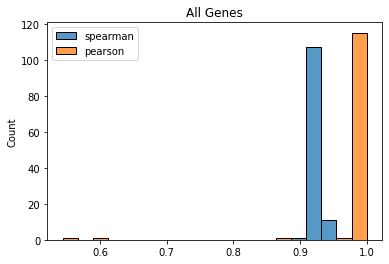

In [40]:
all_correlation = make_correlations(new_columns, orig_columns)
ax = seaborn.histplot(all_correlation)
_ = ax.set_title("All Genes")

The two experiments that performed poorly in pearson skewed the plot, so here's just the spearmans correlations.

<AxesSubplot:xlabel='spearman', ylabel='Count'>

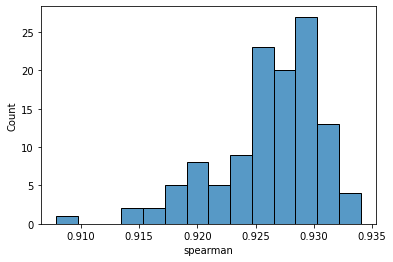

In [41]:
seaborn.histplot(all_correlation["spearman"])

# Protein coding genes

In [42]:
genome_dir = Path("~/proj/genome").expanduser()

with pandas.HDFStore(genome_dir / "GRCh38-V29-male" / "GRCh38-V29-male.h5", "r") as store:
    protein_coding = store.select("/gtf", where="gene_type=='protein_coding'", columns=["gene_id", "gene_name"])

protein_ids = set(protein_coding["gene_id"])
protein_index = [x in protein_ids for x in new_columns.index]

100%|██████████| 117/117 [00:02<00:00, 43.34it/s]


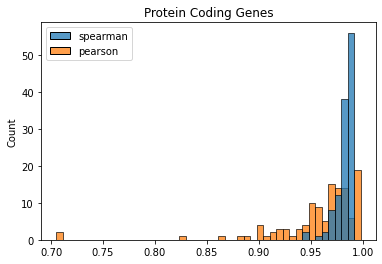

In [43]:
protein_correlation = make_correlations(new_columns, orig_columns, protein_index)
ax = seaborn.histplot(protein_correlation)
_ = ax.set_title("Protein Coding Genes")

# Spikein correlations

100%|██████████| 117/117 [00:02<00:00, 57.91it/s]


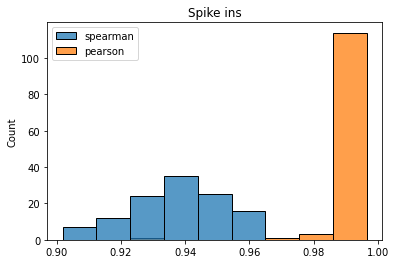

In [44]:
spikes = [x.startswith("gSpikein") for x in new_columns["ENCDO847KYQ"].index]
spike_correlation = make_correlations(new_columns, orig_columns, spikes)
ax = seaborn.histplot(spike_correlation)
_ = ax.set_title("Spike ins")